In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato Leaf Disease Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3076 files belonging to 7 classes.


***Defining Class Names***

In [8]:
class_names = dataset.class_names
class_names

['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']

***Showing the Sample Images From The Dataset According To Class***

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 5 1 4 4 4 6 6 4 4 3 3 1 0 3 1 1 0 4 6 2 0 4 1 4 5 6 4 5 4 6]


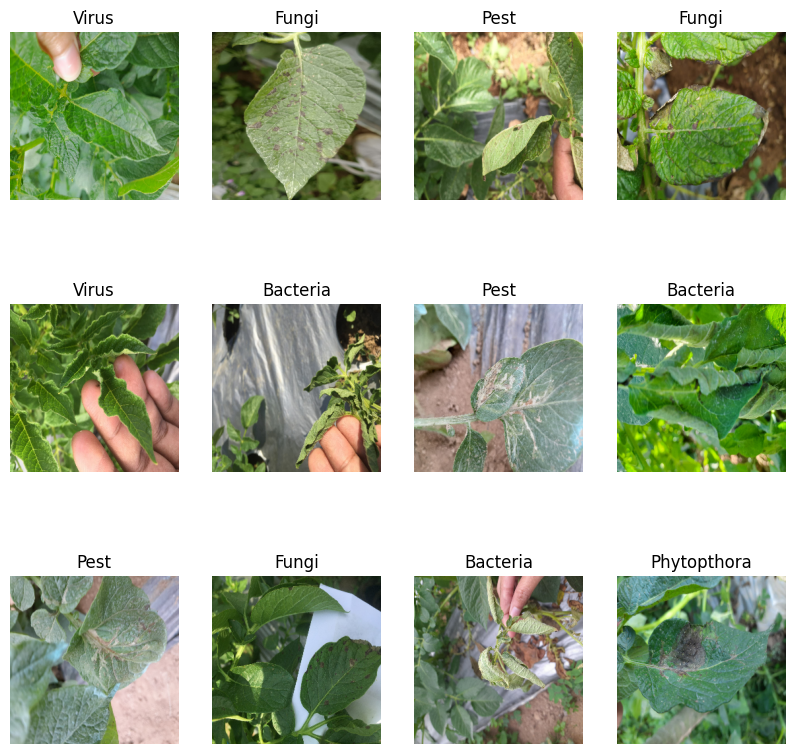

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [15]:
len(dataset)


97

In [18]:
train_size = 0.8
len(dataset)*train_size


77.60000000000001

In [21]:
train_ds = dataset.take(77)
len(train_ds)

77

In [22]:
test_ds = dataset.skip(54)
len(test_ds)

43

In [24]:
val_size=0.1
len(dataset)*val_size

9.700000000000001

In [26]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [28]:
test_ds = test_ds.skip(6)
len(test_ds)

31

***Data Pre-Processing And Augmentation***

In [30]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [32]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [34]:
len(train_ds)

77

In [35]:
len(val_ds)


9

In [37]:
len(test_ds)

11

In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [47]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [49]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

***Summary Of The Model***

In [56]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (32, 7)                │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,007 (718.78 KB)

 Trainable params: 184,007 (718.78 KB)

 Non-trainable params: 0 (0.00 B)

***Model Compilation***

In [58]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [59]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 54s 623ms/step - accuracy: 0.2195 - loss: 1.8410 - val_accuracy: 0.2361 - val_loss: 1.8011
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 44s 569ms/step - accuracy: 0.2554 - loss: 1.7948 - val_accuracy: 0.2292 - val_loss: 1.8123
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 44s 564ms/step - accuracy: 0.2503 - loss: 1.7476 - val_accuracy: 0.2361 - val_loss: 1.7450
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 44s 575ms/step - accuracy: 0.2676 - loss: 1.7363 - val_accuracy: 0.3090 - val_loss: 1.7351
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 44s 565ms/step - accuracy: 0.3420 - loss: 1.6439 - val_accuracy: 0.3264 - val_loss: 1.6662
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 44s 571ms/step - accuracy: 0.3817 - loss: 1.5476 - val_accuracy: 0.3056 - val_loss: 1.6229
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 44s 567ms/step - accuracy: 0.4042 - loss: 1.5063 - val_accuracy: 0.3646 - val_loss: 1.5956
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 44s 565ms/step - accuracy: 0.4073 - loss: 1.4627 - val_accu

In [60]:
scores = model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.6467 - loss: 0.8330


In [61]:
scores

[0.8741163611412048, 0.6278409361839294]

In [62]:
history

In [63]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 77}

In [65]:
len(history.history['loss'])

50

***Showing Loss For First 10 Epochs***

In [67]:
history.history['loss'][:10]

[1.820787787437439,
 1.7934173345565796,
 1.7512927055358887,
 1.7135154008865356,
 1.640990972518921,
 1.5366443395614624,
 1.504028558731079,
 1.44646155834198,
 1.4376981258392334,
 1.3868298530578613]

***Showing History For Accuracy And Losss***

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Total Training Accuracy: 0.54
Total Validation Accuracy: 0.54


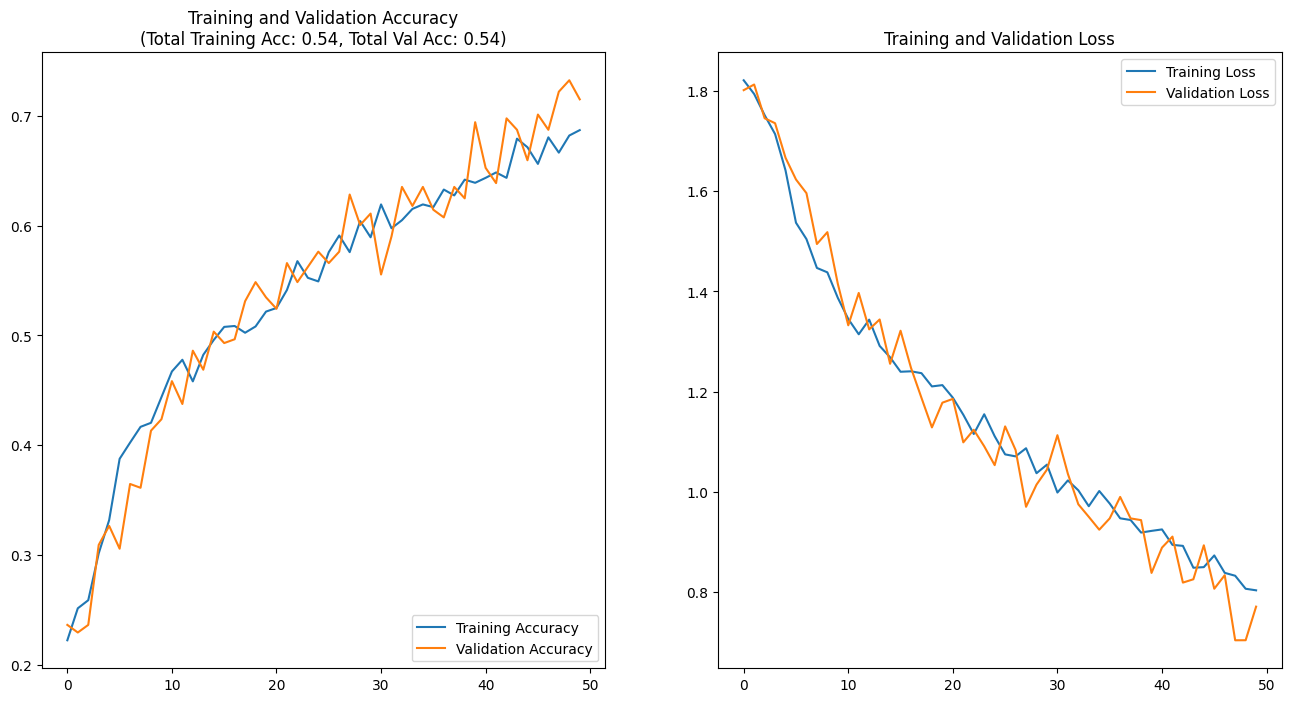

In [73]:
import matplotlib.pyplot as plt


# Calculating total (mean) training and validation accuracy
total_training_acc = sum(acc) / len(acc)
total_val_acc = sum(val_acc) / len(val_acc)


print(f'Total Training Accuracy: {total_training_acc:.2f}')
print(f'Total Validation Accuracy: {total_val_acc:.2f}')

# Plotting training & validation accuracy and loss

plt.figure(figsize=(16, 8))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy\n(Total Training Acc: {total_training_acc:.2f}, Total Val Acc: {total_val_acc:.2f})')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

***Showing Predicted Scores using Precision, F1 Score, recall and mAP***

In [74]:
import numpy as np
from sklearn.metrics import classification_report, average_precision_score

y_true = []
y_pred = []
y_scores = []  # Predicted scores for calculating AP
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    y_scores.extend(predictions)

class_report = classification_report(y_true, y_pred, target_names=class_names)
print(class_report)

# Calculate mAP
average_precision = average_precision_score(np.array(y_true), np.array(y_scores), average=None)
mAP = np.mean(average_precision)
print(f'Total mAP: {mAP:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

    Bacteria       0.98      0.76      0.86        68
       Fungi       0.52      0.68      0.59        84
     Healthy       0.31      0.24      0.27        17
    Nematode       0.56      0.83      0.67         6
        Pest       0.66      0.34      0.45        73
 Phytopthora       0.70      0.55      0.61        42
       Virus       0.57      0.89      0.70        62

    accuracy                           0.63       352
   macro avg       0.61      0.61      0.59       352
weighted avg       0.66      0.63  

***Testing The prediction label and Actual Label***

first image to predict
actual label: Fungi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
predicted label: Fungi


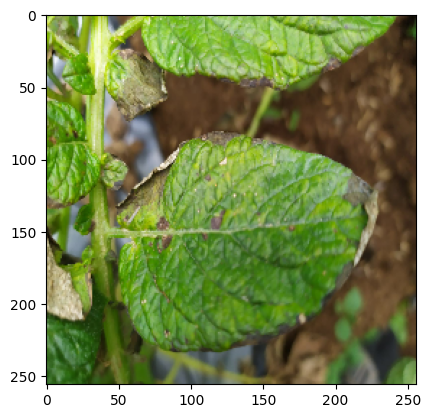

In [75]:

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [77]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

***Predicting multiple images from dataset compared with actual and learning rate confidence***


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


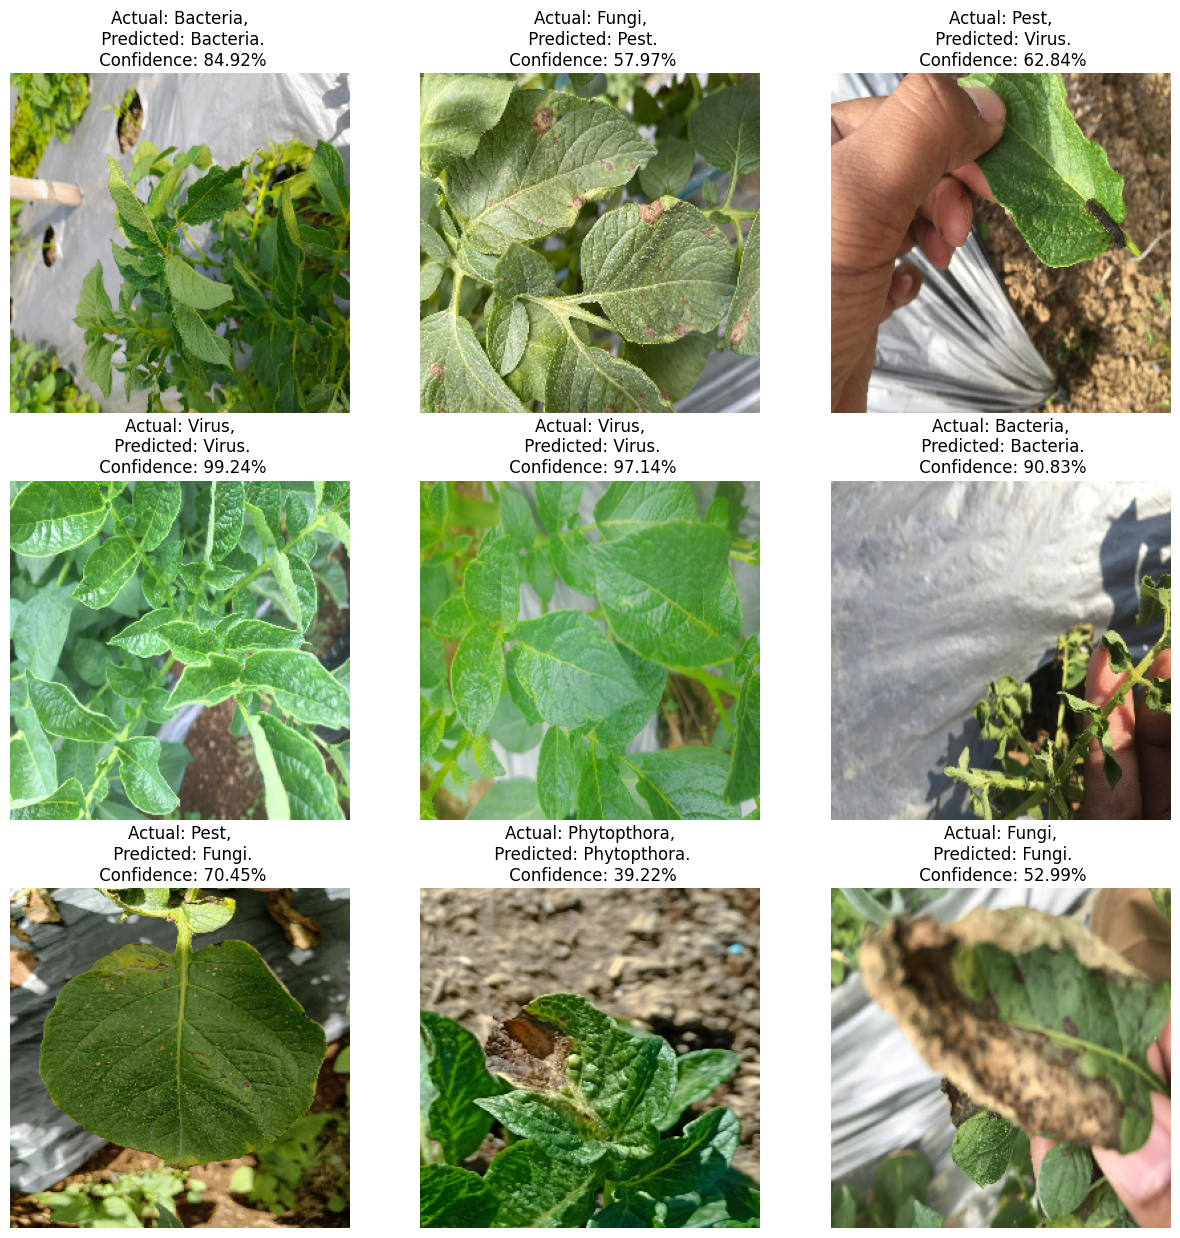

In [78]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")